In [ ]:
!pip install torch torchvision

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-07-29 20:02:27--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.48, 13.224.29.60, 13.224.29.19, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  30.6MB/s    in 1.5s    

2020-07-29 20:02:29 (30.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!apt install unzip
!unzip -o hymenoptera_data.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/12

In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()


В DataLoader() выше стоит "shuffle=True". Для чего это нужно?
ответ: Shufle=True метка сообщает что наш датасет будет перетасован
Сколько картинок будет в каждом батче?
ответ: 4

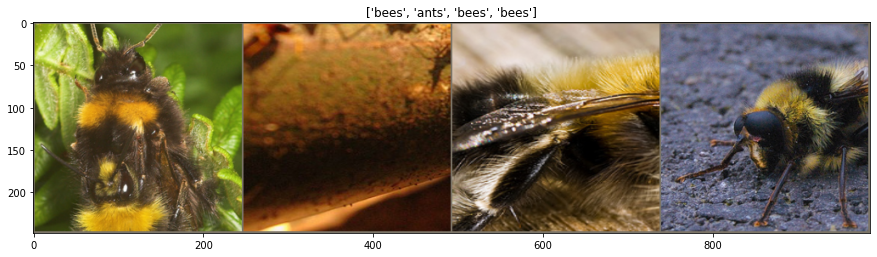

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-1.6384, -1.6384, -1.6042,  ..., -1.5357, -1.4672, -1.4843],
         [-1.6727, -1.6727, -1.6555,  ..., -1.5870, -1.5357, -1.5357],
         [-1.6898, -1.6898, -1.6727,  ..., -1.5699, -1.5699, -1.5528],
         ...,
         [-0.2856, -0.2856, -0.2856,  ..., -0.2856, -0.2856, -0.2856],
         [-0.1143, -0.1143, -0.1143,  ..., -0.1143, -0.1143, -0.1143],
         [ 0.0398,  0.0398,  0.0398,  ...,  0.0398,  0.0398,  0.0398]],

        [[-0.9853, -1.0203, -1.0378,  ..., -0.7052, -0.6001, -0.6176],
         [-1.0203, -1.0553, -1.0903,  ..., -0.7227, -0.6702, -0.6702],
         [-1.0378, -1.0728, -1.1078,  ..., -0.7052, -0.7052, -0.6877],
         ...,
         [-0.1625, -0.1625, -0.1625,  ..., -0.1625, -0.1625, -0.1625],
         [ 0.0126,  0.0126,  0.0126,  ...,  0.0126,  0.0126,  0.0126],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.1702,  0.1702,  0.1702]],

        [[-0.9504, -0.9678, -0.9678,  ..., -0.4973, -0.3927, -0.4101],
         [-0.9853, -1.0027, -1.0201,  ..., -0

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        print(torch.sum(predicted == labels))
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [ ]:
model_extractor = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model_extractor.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2288 Acc: 0.5656
val Loss: 0.1767 Acc: 0.4967

Epoch 1/24
----------
train Loss: 0.1760 Acc: 0.5000
val Loss: 0.1727 Acc: 0.6209

Epoch 2/24
----------
train Loss: 0.1745 Acc: 0.5574
val Loss: 0.1726 Acc: 0.6405

Epoch 3/24
----------
train Loss: 0.1696 Acc: 0.6025
val Loss: 0.1437 Acc: 0.7124

Epoch 4/24
----------
train Loss: 0.1611 Acc: 0.6189
val Loss: 0.1592 Acc: 0.6536

Epoch 5/24
----------
train Loss: 0.1399 Acc: 0.7541
val Loss: 0.1602 Acc: 0.6797

Epoch 6/24
----------
train Loss: 0.1556 Acc: 0.6557
val Loss: 0.1394 Acc: 0.7320

Epoch 7/24
----------
train Loss: 0.1358 Acc: 0.7049
val Loss: 0.1294 Acc: 0.7582

Epoch 8/24
----------
train Loss: 0.1257 Acc: 0.7295
val Loss: 0.1217 Acc: 0.8105

Epoch 9/24
----------
train Loss: 0.1206 Acc: 0.7623
val Loss: 0.1139 Acc: 0.8366

Epoch 10/24
----------
train Loss: 0.0995 Acc: 0.7910
val Loss: 0.1127 Acc: 0.8170

Epoch 11/24
----------
train Loss: 0.1001 Acc: 0.8033
val Loss: 0.0932 Acc: 0.8627

Epoch 12/24
----------
t

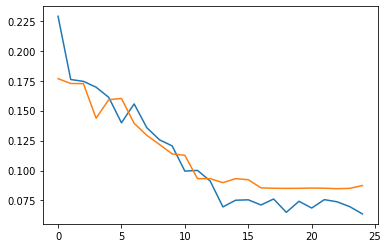

In [ ]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG-16_fine_tune.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('VGG-16_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

tensor(4)
tensor(3)
tensor(3)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(2)
tensor(4)
tensor(3)
tensor(2)
tensor(4)
tensor(3)
tensor(4)
tensor(2)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(1)
Accuracy: 0.8758
